# ORB from Andrew Aziz's paper on SSRN

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4416622

In [14]:
pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.7 MB/s eta 0:00:00


In [15]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import nest_asyncio
import yfinance as yf
import quantstats as qs
import mplfinance as mpf

In [6]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [7]:
df = pd.read_csv("/content/drive/MyDrive/QQQ_2020-2023_5min.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.rename(columns={
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume'
        }, inplace=True)
df

,open,close,low,high,volume
date,,,,,
2020-01-02 09:30:00,214.400,214.730,214.26,214.82,1800040
2020-01-02 09:35:00,214.730,215.040,214.72,215.13,815067
2020-01-02 09:40:00,215.040,214.955,214.91,215.16,541516
2020-01-02 09:45:00,214.955,214.810,214.80,215.02,326171
2020-01-02 09:50:00,214.805,214.780,214.69,214.92,419920
...,...,...,...,...,...
2023-12-29 15:35:00,409.620,409.730,409.62,409.79,313407
2023-12-29 15:40:00,409.730,409.530,409.53,409.90,441468
2023-12-29 15:45:00,409.530,409.470,409.43,409.66,428592


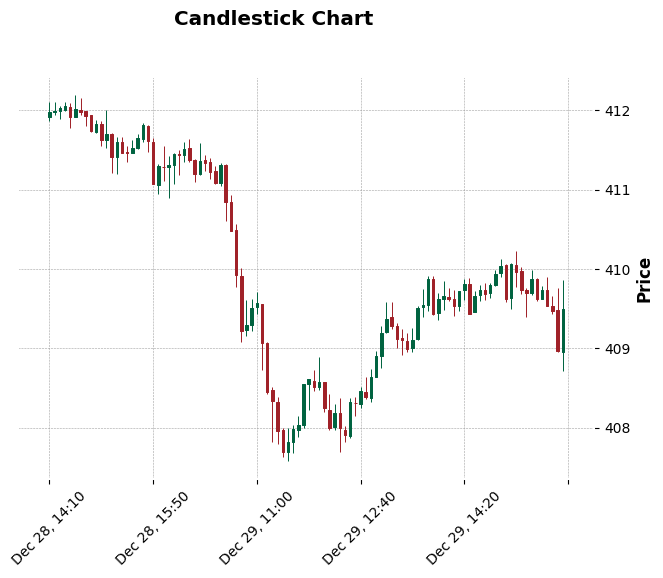

In [19]:
mpf.plot(df.tail(100), type='candle', style='charles', title='Candlestick Chart', ylabel='Price')

In [8]:

# Define the inputs
capital = 25000           # Initial account value
leverage = 4              # Leverage multiplier
commission_per_share = 0.0035       # Comission fees and slippage
account_risk=0.01         # Percentage of total account risked per trade
profit_multiplier=10      # Profit target multiplier from entry price


#first_column_index = df.index

df = df[['open', 'high', 'low', 'close', 'volume']]
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df['RSI']=ta.rsi(df.Close, length=16)
df





<ipython-input-8-387a57568094>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI']=ta.rsi(df.Close, length=16)


,Open,High,Low,Close,Volume,RSI
date,,,,,,
2020-01-02 09:30:00,214.400,214.82,214.26,214.730,1800040,NaN
2020-01-02 09:35:00,214.730,215.13,214.72,215.040,815067,NaN
2020-01-02 09:40:00,215.040,215.16,214.91,214.955,541516,NaN
2020-01-02 09:45:00,214.955,215.02,214.80,214.810,326171,NaN
2020-01-02 09:50:00,214.805,214.92,214.69,214.780,419920,NaN
...,...,...,...,...,...,...
2023-12-29 15:35:00,409.620,409.79,409.62,409.730,313407,52.383807
2023-12-29 15:40:00,409.730,409.90,409.53,409.530,441468,48.794154
2023-12-29 15:45:00,409.530,409.66,409.43,409.470,428592,47.747139


In [108]:
# Function to calculate ORB strategy
entry_price = None
def apply_orb_strategy(data, capital, leverage, commission_per_share):
    df_results = pd.DataFrame()
    length = (len(data.groupby(data.index.date)))
    df_results['Date'] = None
    df_results['Date'] = df_results['Date'].reindex(range(length), fill_value=None)  # Pad with zeros if needed
    df_results['ORB QQQ'] = ""
    df_results['ORB QQQ'] = df_results['ORB QQQ'].reindex(range(length), fill_value=None)  # Pad with zeros if needed
    df_results['Buy and Hold QQQ'] = ""
    df_results['Buy and Hold QQQ'] = df_results['Buy and Hold QQQ'].reindex(range(length), fill_value=None)  # Pad with zeros if needed
    buy_points = {'date':[],"price":[]}
    sell_points = {'date':[],"price":[]}
    results = []
    total_cap=capital
    count = 0
    initial_hold_quantity = capital/data['Close'][0]
    for date, day_data in data.groupby(data.index.date):
        day_data = day_data.reset_index()
        if day_data.empty or len(day_data) < 2:
            continue  # Skip if there's no data or not enough candles
        # Define the first 5-minute range
        opening_range = day_data.loc[0]
        open_price = opening_range['Open']
        high_price = opening_range['High']
        low_price = opening_range['Low']
        close_price = opening_range['Close']
        day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_of_week = day_names[date.weekday()]
        if close_price > open_price:# Bullish first candle
          if day_of_week == 'Tuesday':
            print((day_of_week=='Tuesday'))
            entry_price = day_data.loc[1, 'Open']
            stop_loss = low_price
            direction = 2
          else:
            entry_price = day_data.loc[1, 'Open']
            stop_loss = low_price
            direction = 1
          buy_points['date'].append(date)
          buy_points['price'].append(entry_price)

        elif close_price < open_price: # Bearish first candle
          if day_of_week == 'Tuesday':
            entry_price = day_data.loc[1, 'Open']
            stop_loss = high_price
            direction = -2
          else:
            entry_price = day_data.loc[1, 'Open']
            stop_loss = high_price
            direction = -1
          sell_points['date'].append(date)
          sell_points['price'].append(entry_price)
        else:
          direction = 0
          continue

        # Calculate risk per trade
        risk_per_trade = account_risk * capital
        shares = risk_per_trade / abs(entry_price - stop_loss)
        shares = min(shares, capital * leverage / entry_price)  # Adjust for leverage

        profit_target = entry_price + direction * profit_multiplier * abs(entry_price - stop_loss)
        trade_commission = commission_per_share * shares

        for idx, row in day_data.iterrows():
            if idx <= 1:
                continue  # Skip the first two rows

            current_price = row['Open']
            if (direction == 1 or direction == 2) and current_price >= profit_target:
                exit_price = profit_target
                sell_points['date'].append(date)
                sell_points['price'].append(exit_price)
                break
            elif (direction == -1 or direction == -2) and current_price <= profit_target:
                exit_price = profit_target
                buy_points['date'].append(date)
                buy_points['price'].append(exit_price)
                break
            elif (direction == 1 or direction == 2) and current_price <= stop_loss:
                exit_price = stop_loss
                sell_points['date'].append(date)
                sell_points['price'].append(exit_price)
                break
            elif (direction == -1 or direction == -2) and current_price >= stop_loss:
                exit_price = stop_loss
                buy_points['date'].append(date)
                buy_points['price'].append(exit_price)
                break
        else:
            exit_price = day_data.loc[len(day_data) - 1, 'Close']  # End of day exit
            if len(buy_points['price']) > len(sell_points['price']):
              sell_points['date'].append(date)
              sell_points['price'].append(exit_price)
            else:
              buy_points['date'].append(date)
              buy_points['price'].append(exit_price)

        trade_profit = direction * (exit_price - entry_price) * shares
        trade_profit -= trade_commission
        total_cap+=trade_profit
        results.append(total_cap)
        df_results['Date'].iloc[count] = date
        df_results['ORB QQQ'].iloc[count] = total_cap
        df_results['Buy and Hold QQQ'].iloc[count] = initial_hold_quantity*day_data.loc[len(day_data) - 1, 'Close']
        count+=1
    sell_points['date'] = pd.to_datetime(sell_points['date'])
    buy_points['date'] = pd.to_datetime(sell_points['date'])
    buy_markers = pd.Series(buy_points['price'], index=buy_points['date'])
    sell_markers = pd.Series(sell_points['price'], index=sell_points['date'])
    return df_results,buy_markers,sell_markers

# Apply the strategy
strategy_results,buy_markers,sell_markers = apply_orb_strategy(df, capital, leverage, commission_per_share)
strategy_results=strategy_results.dropna()
strategy_results['Date'] = pd.to_datetime(strategy_results['Date'])
strategy_results.set_index('Date', inplace=True)


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


[*********************100%%**********************]  1 of 1 completed


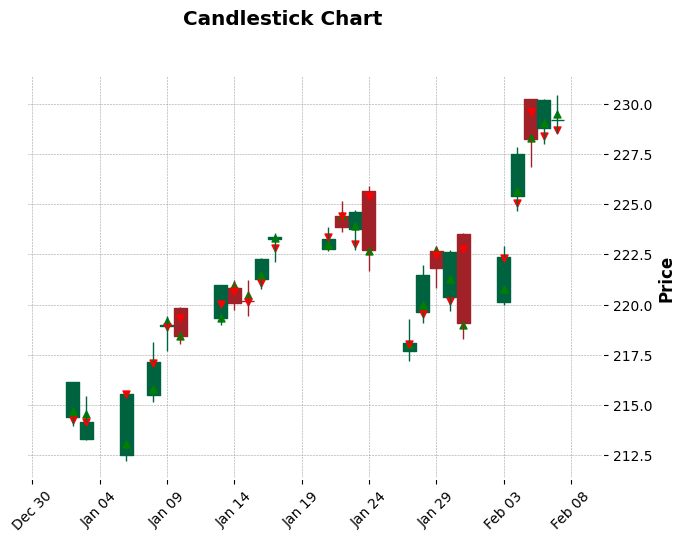

In [109]:

QQQ = yf.download("QQQ",period="1d",start="2020-1-1")
buy_markers = buy_markers.reindex(QQQ.index)
sell_markers = sell_markers.reindex(QQQ.index)
buy_markers = buy_markers.dropna()
sell_markers = sell_markers.dropna()
QQQ['Buy Price'] = buy_markers
QQQ['Sell Price'] = sell_markers
QQQ = QQQ.dropna()
buy_plot = mpf.make_addplot(QQQ.head(25)['Buy Price'], type='scatter', markersize=25, marker='^', color='green')
sell_plot = mpf.make_addplot(QQQ.head(25)['Sell Price'], type='scatter', markersize=25, marker='v', color='red')
mpf.plot(QQQ.head(25), type='candle', style='charles', title='Candlestick Chart', ylabel='Price', addplot=[buy_plot, sell_plot], show_nontrading=True)


In [110]:
strategy_results["ORB PnL"] = 0
for i in range(1,len(strategy_results)):
  strategy_results["ORB PnL"].iloc[i] = strategy_results["ORB QQQ"].iloc[i]-strategy_results["ORB QQQ"].iloc[i-1]
day_of_week = strategy_results.index.day_name()
strategy_results['Day of Week'] = day_of_week
strategy_results

<ipython-input-110-1a795a788b57>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strategy_results["ORB PnL"].iloc[i] = strategy_results["ORB QQQ"].iloc[i]-strategy_results["ORB QQQ"].iloc[i-1]


,ORB QQQ,Buy and Hold QQQ,ORB PnL,Day of Week
Date,,,,
2020-01-02,24779.490523,25164.159642,0.000000,Thursday
2020-01-03,24703.230833,24935.966097,-76.259690,Friday
2020-01-06,25443.140472,25093.140223,739.909639,Monday
2020-01-08,25941.794318,25277.092162,498.653846,Wednesday
2020-01-09,25812.500039,25500.593769,-129.294279,Thursday
...,...,...,...,...
2023-12-21,118426.05887,47478.228473,-248.833783,Thursday
2023-12-22,118290.71887,47545.755134,-135.340000,Friday
2023-12-26,118836.526172,47836.81833,545.807302,Tuesday


In [111]:
strategy_results['Positive'] = strategy_results["ORB PnL"]>0
strategy_results['Negative'] = strategy_results["ORB PnL"]<0
weekly_pnl = strategy_results.groupby('Day of Week')['ORB PnL'].sum()
counts = strategy_results.groupby('Day of Week').agg(
    Positive_Count=('Positive', 'sum'),
    Negative_Count=('Negative', 'sum')
)
print(counts)
print("\n",weekly_pnl)


             Positive_Count  Negative_Count
Day of Week                                
Friday                   63             137
Monday                   52             131
Thursday                 54             150
Tuesday                  70             134
Wednesday                51             157

 Day of Week
Friday       20246.740127
Monday        6165.614571
Thursday     13881.072998
Tuesday      46730.239640
Wednesday     7135.767822
Name: ORB PnL, dtype: float64


In [11]:
df_hour = pd.read_csv("/content/drive/MyDrive/QQQ_2020-2024_1hour.csv")
df_hour['date'] = pd.to_datetime(df_hour['date'])
df_hour.set_index('date', inplace=True)
df_hour.rename(columns={
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume'
        }, inplace=True)
df_hour['date'] = df_hour.index.date
df_hour['date'] = pd.to_datetime(df_hour['date'])
df_hour

,open,close,low,high,volume,date
date,,,,,,
2020-01-02 09:00:00,214.400,215.0800,214.2600,215.160,4231014,2020-01-02
2020-01-02 10:00:00,215.070,214.6200,213.9800,215.110,3224223,2020-01-02
2020-01-02 11:00:00,214.630,214.6500,214.0800,214.750,1874313,2020-01-02
2020-01-02 12:00:00,214.650,215.0250,214.5900,215.050,1443454,2020-01-02
2020-01-02 13:00:00,215.020,215.0154,214.7800,215.025,1417272,2020-01-02
...,...,...,...,...,...,...
2024-03-28 11:00:00,444.820,445.0000,444.3500,445.080,2854203,2024-03-28
2024-03-28 12:00:00,445.011,444.3200,444.0000,445.030,2444421,2024-03-28
2024-03-28 13:00:00,444.320,444.1000,443.7313,444.380,1886927,2024-03-28


In [12]:
neg_pnl = strategy_results['ORB PnL'] < 0

# Extract the indexes (dates) of these rows
neg_days = strategy_results.index[neg_pnl]
common_dates = set(df_hour['date']).intersection(set(neg_days))
df_hour_neg = df_hour[df_hour['date'].isin(common_dates)]
#df_hour_pos = ~df_hour[df_hour['date'].isin(common_dates)]
print(df_hour_neg)
#print(df_hour_pos)

                       open     close       low      high   volume       date
date                                                                         
2020-01-03 09:00:00  213.29  214.6100  213.2800  214.9500  4021866 2020-01-03
2020-01-03 10:00:00  214.57  214.4265  214.1000  214.8800  3646527 2020-01-03
2020-01-03 11:00:00  214.44  214.8100  214.1154  214.8900  1693801 2020-01-03
2020-01-03 12:00:00  214.81  215.2699  214.8000  215.4700  2035657 2020-01-03
2020-01-03 13:00:00  215.27  214.8053  214.3500  215.3360  2651804 2020-01-03
...                     ...       ...       ...       ...      ...        ...
2023-12-27 11:00:00  410.61  410.8800  410.2900  411.0800  2587707 2023-12-27
2023-12-27 12:00:00  410.88  410.5900  410.3600  411.0700  2100848 2023-12-27
2023-12-27 13:00:00  410.58  411.2750  410.5800  411.7875  3837596 2023-12-27
2023-12-27 14:00:00  411.27  410.6800  410.2250  411.3200  4064304 2023-12-27
2023-12-27 15:00:00  410.69  411.4700  410.5400  411.5200  48159

In [13]:
"""
QQQ = yf.download("QQQ",period="1d",start="2020-1-1")
QQQ['RSI']=ta.rsi(QQQ.Close, length=16)
pos_days = ~QQQ.index.isin(neg_days)
"""
df_hour_neg["RSI"] = ta.rsi(df_hour_neg.close,length=16)
#df_hour_neg = df_hour_neg[df_hour_neg.index.time == pd.to_datetime('09:00:00').time()]
df_hour_neg
#print(QQQ[pos_days]["RSI"].describe())
#print(QQQ.loc[neg_days]["RSI"].describe())


<ipython-input-13-bc7e18ee3f99>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hour_neg["RSI"] = ta.rsi(df_hour_neg.close,length=16)


,open,close,low,high,volume,date,RSI
date,,,,,,,
2020-01-03 09:00:00,213.29,214.6100,213.2800,214.9500,4021866,2020-01-03,NaN
2020-01-03 10:00:00,214.57,214.4265,214.1000,214.8800,3646527,2020-01-03,NaN
2020-01-03 11:00:00,214.44,214.8100,214.1154,214.8900,1693801,2020-01-03,NaN
2020-01-03 12:00:00,214.81,215.2699,214.8000,215.4700,2035657,2020-01-03,NaN
2020-01-03 13:00:00,215.27,214.8053,214.3500,215.3360,2651804,2020-01-03,NaN
...,...,...,...,...,...,...,...
2023-12-27 11:00:00,410.61,410.8800,410.2900,411.0800,2587707,2023-12-27,64.378129
2023-12-27 12:00:00,410.88,410.5900,410.3600,411.0700,2100848,2023-12-27,63.224368
2023-12-27 13:00:00,410.58,411.2750,410.5800,411.7875,3837596,2023-12-27,64.813202


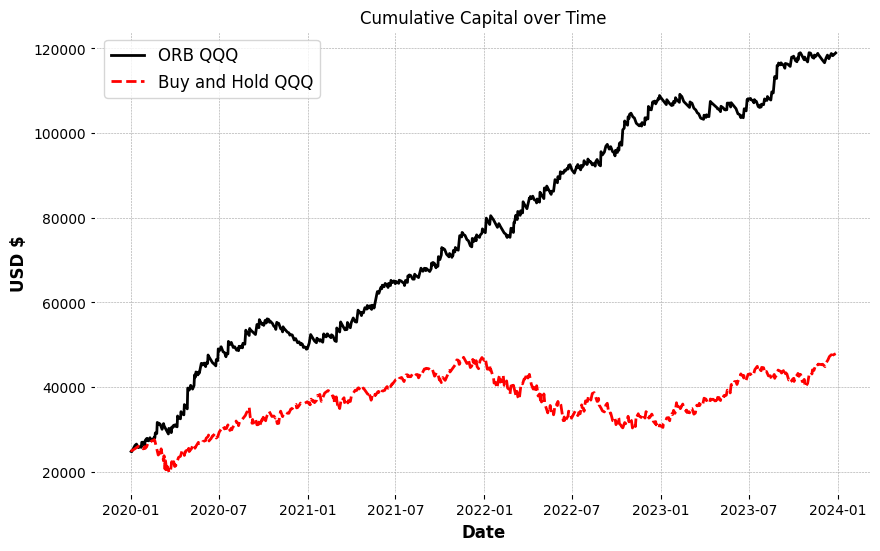

In [112]:
plt.figure(figsize=(10, 6))
plt.plot(strategy_results['ORB QQQ'], label = "ORB QQQ", color='black')
plt.plot(strategy_results['Buy and Hold QQQ'], label = "Buy and Hold QQQ" , color='red',linestyle = "--")
# Adding labels and title
plt.xlabel('Date')
plt.ylabel('USD $')
plt.title('Cumulative Capital over Time')
plt.legend(loc='upper left',fontsize='large')
plt.grid(True)

# Show the plot
plt.show()

In [113]:
Cumulative_Returns_ORB = 100*(strategy_results["ORB QQQ"][-1]-25000)/25000
print("ORB Strategy Final Total Capital: {} $".format((strategy_results["ORB QQQ"][-1]).round(2)))
print(f"Total Cumulative Returns ORB Strategy {Cumulative_Returns_ORB.round(2)}%")
print("Buy and Hold Final Total Capital: {} $".format((strategy_results["Buy and Hold QQQ"][-1]).round(2)))
Cum_Returns_BuyaandHold = (100*(strategy_results["Buy and Hold QQQ"][-1]-25000)/25000).round(2)
print(f"Total Cumulative Returns Buy and Hold: {Cum_Returns_BuyaandHold}%")


ORB Strategy Final Total Capital: 118938.93 $
Total Cumulative Returns ORB Strategy 375.76%
Buy and Hold Final Total Capital: 47885.72 $
Total Cumulative Returns Buy and Hold: 91.54%


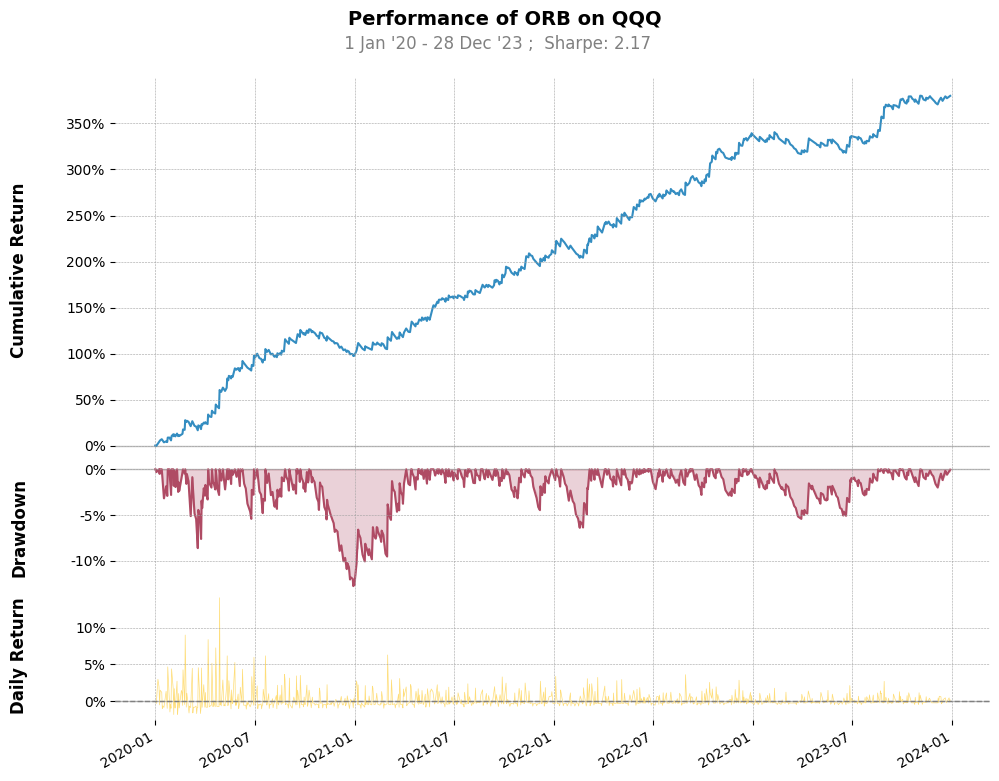

In [114]:
qs.plots.snapshot(strategy_results["ORB QQQ"], title='Performance of ORB on QQQ', show=True)

[*********************100%%**********************]  1 of 1 completed


[Performance Metrics]



                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-01-03   2020-01-03
End Period                 2023-12-28   2023-12-28
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          90.28%       298.88%
CAGR﹪                     11.79%       27.08%

Sharpe                     0.73         2.27
Prob. Sharpe Ratio         92.52%       100.0%
Smart Sharpe               0.65         2.03
Sortino                    1.03         6.59
Smart Sortino              0.92         5.89
Sortino/√2                 0.73         4.66
Smart Sortino/√2           0.65         4.16
Omega                      1.55         1.55

Max Drawdown               -35.62%      -10.11%
Longest DD Days            753          172
Volatility (ann.)          27.35%       15.94%
R^2                        0.0          0.0
Information Ratio          0.03         0.03
Calmar             

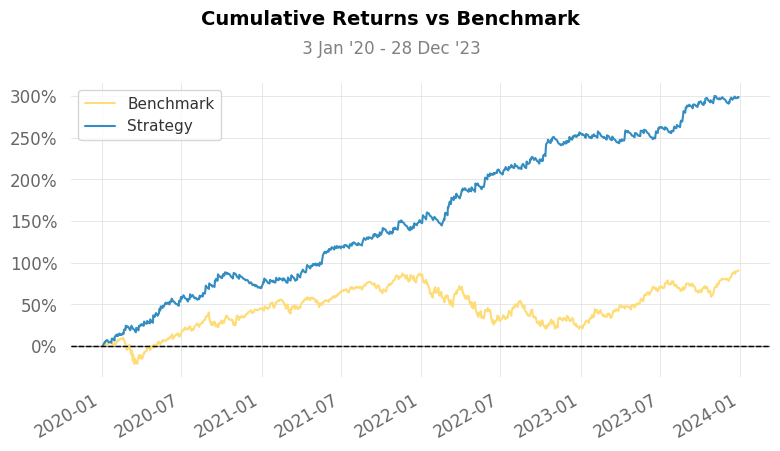

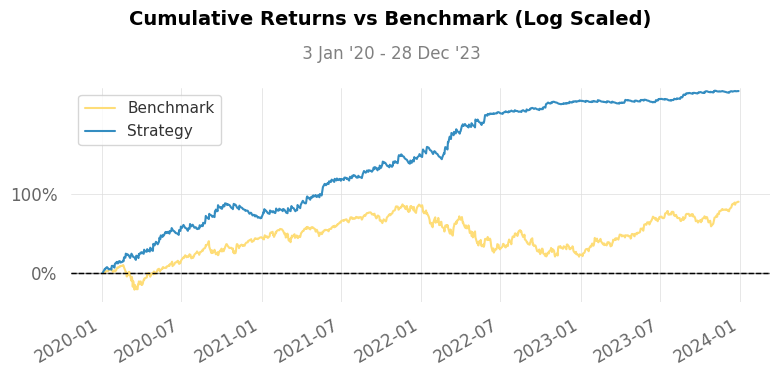

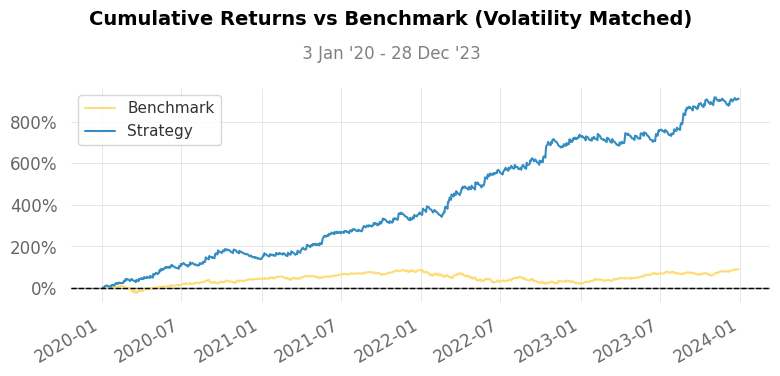

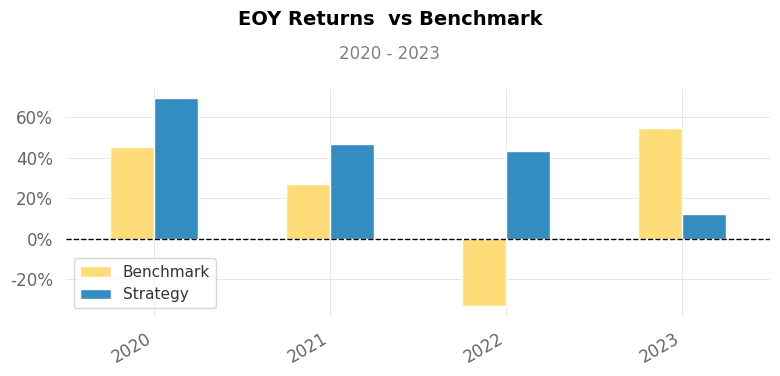

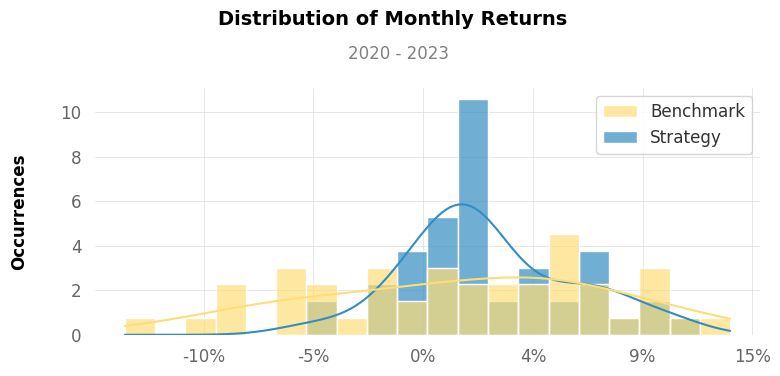

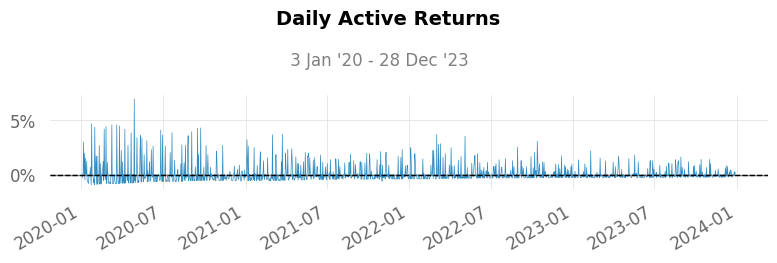

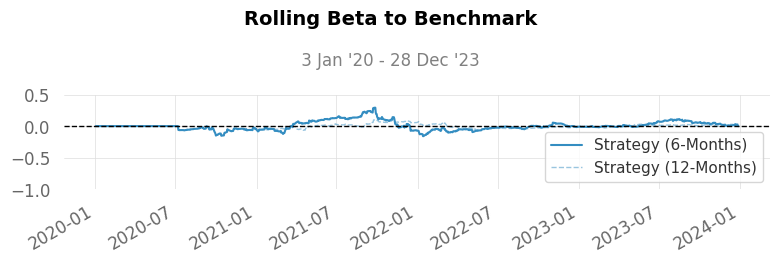

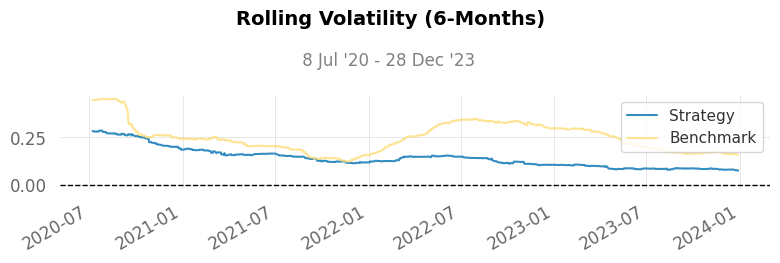

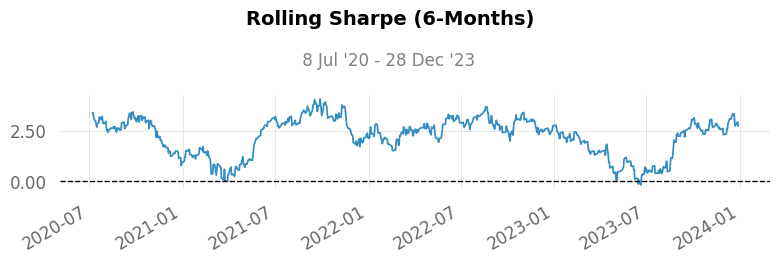

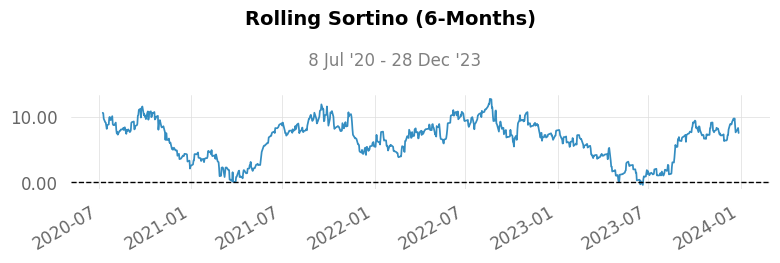

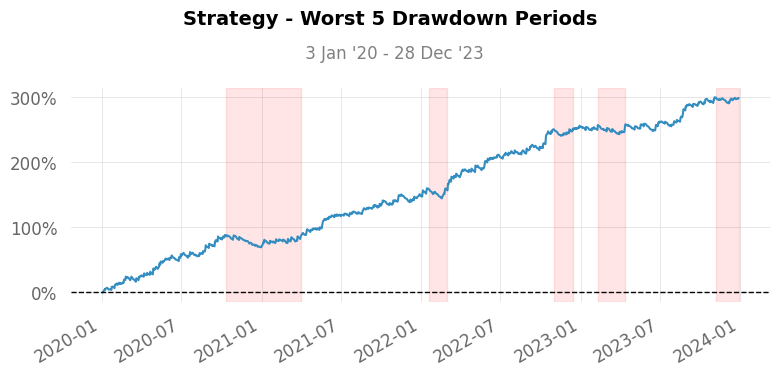

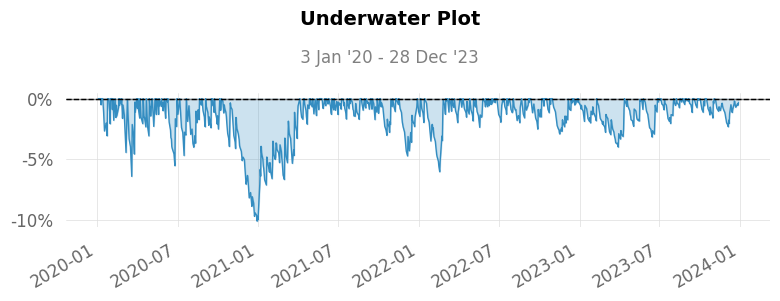

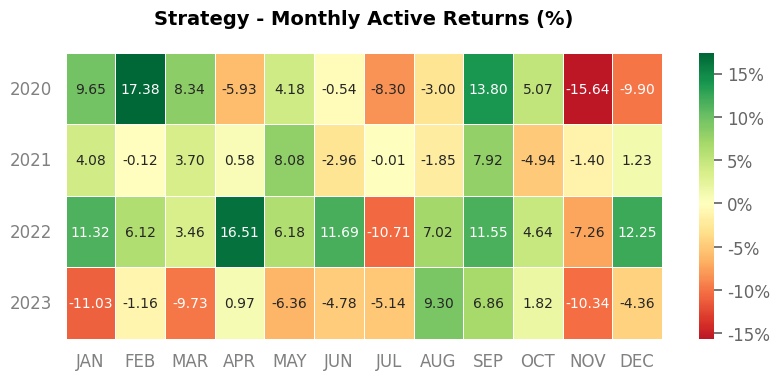

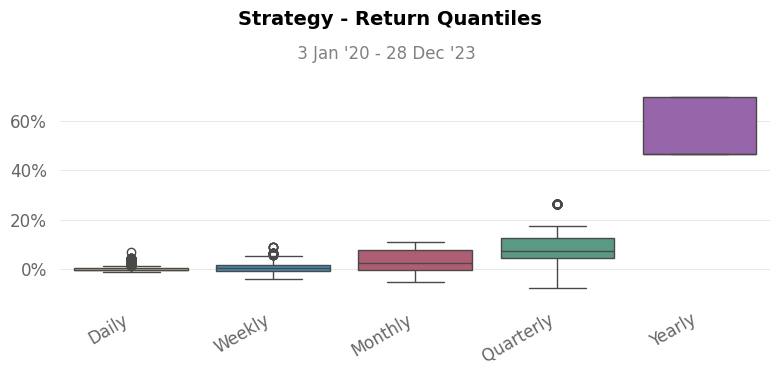

In [ ]:
qs.reports.full(strategy_results["ORB QQQ"], benchmark='QQQ')

In [115]:
from scipy import stats
t_stat, p_value = stats.ttest_ind(strategy_results["ORB QQQ"], strategy_results["Buy and Hold QQQ"])
print("T-Statistic:", t_stat)
print("P-Value:", p_value)


ValueError: data type <class 'numpy.object_'> not inexact

In [116]:
# Calculate the mean and standard deviation of strategy returns
mean_return = np.mean(strategy_results["ORB QQQ"])
std_return = np.std(strategy_results["ORB QQQ"])

# Calculate Z-Score for a specific return (e.g., first return in the strategy returns)
specific_return = strategy_results["ORB QQQ"][0]
z_score = (specific_return - mean_return) / std_return

print("Z-Score:", z_score)


Z-Score: -1.9450327546743051


In [117]:
import statsmodels.api as sm

# Add a constant to the independent variable (benchmark returns)
benchmark_returns = sm.add_constant(strategy_results["Buy and Hold QQQ"])

# Fit the regression model
model = sm.OLS(strategy_results["ORB QQQ"], strategy_results["Buy and Hold QQQ"]).fit()

# Print the regression results
print(model.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).